# CITE-seq Profiling of Murine Spleen and Lymph Nodes

We showcase a standard workflow with {MODEL} on a large multi-omic dataset of CITE-seq profiled immune cells from murine spleen and lymph nodes.
Samples consist of two batches that were processed on different days, thereby introducing technical variation between the groups. 
Given that publicly available gene sets consist of gene symbols, we inform only the RNA modality. In that regard, we utilize the Hallmark annotations from the mouse MSigDB\{CITE}. Additionally, we append cell type signatures from a single-cell mouse cell atlas (MCA)\CITE{https://pubmed.ncbi.nlm.nih.gov/29474909/}, resulting in 56 distinct gene sets with a median size of 69 genes. We train {MODEL} with the default parameters, which include 3 additional uninformed factors.

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch

In [4]:
# import muvi

from famo.core import CORE
from famo.utils_gpu import get_free_gpu_idx
from famo.plotting import (
    plot_factor,
    plot_factor_correlation,
    plot_top_weights,
    plot_training_curve,
    plot_variance_explained,
    plot_weights,
)

In [5]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f384164f220>


In [6]:
# plotting settings
# sns.set()
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [7]:
device = "cpu"
try:
    device = f"cuda:{get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:2'

In [8]:
adata = sc.read_h5ad("/home/aqoku/projects/data/famo/sce.h5ad")
adata.X = np.array(adata.layers["logcounts"].todense(), dtype=np.float32)
adata

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 47681 × 33538
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialDE_pool_P

In [9]:
adata.obs["sample_name"].value_counts()

151509    4789
151510    4634
151508    4384
151507    4226
151671    4110
151672    4015
151674    3673
151669    3661
151673    3639
151675    3592
151670    3498
151676    3460
Name: sample_name, dtype: int64

In [10]:
for sn in adata.obs["sample_name"].unique():
    print(sn)
    sample_samples = adata.obs["sample_name"] == sn
    subset_df = pd.DataFrame(adata.X[sample_samples, :], index=adata.obs_names[sample_samples], columns=adata.var_names)
    print(subset_df.std().sort_values(ascending=False))
    print((subset_df.std() > 0).sum())

151507
ENSG00000110484    1.749028
ENSG00000131095    1.415413
ENSG00000197971    1.314138
ENSG00000123560    1.295197
ENSG00000124935    1.245088
                     ...   
ENSG00000259792    0.000000
ENSG00000183476    0.000000
ENSG00000260988    0.000000
ENSG00000259708    0.000000
ENSG00000279073    0.000000
Length: 33538, dtype: float32
21151
151508
ENSG00000110484    1.829127
ENSG00000131095    1.452026
ENSG00000197971    1.352827
ENSG00000124935    1.302167
ENSG00000123560    1.293691
                     ...   
ENSG00000278013    0.000000
ENSG00000259442    0.000000
ENSG00000259805    0.000000
ENSG00000260608    0.000000
ENSG00000277782    0.000000
Length: 33538, dtype: float32
20737
151509
ENSG00000110484    1.753246
ENSG00000131095    1.439502
ENSG00000197971    1.290402
ENSG00000123560    1.270190
ENSG00000124935    1.246376
                     ...   
ENSG00000258616    0.000000
ENSG00000165496    0.000000
ENSG00000258751    0.000000
ENSG00000258949    0.000000
ENSG0000025

In [11]:
adata_subset = adata[(~adata.obs["discard"]) & (adata.obs["sample_name"] == 151508), :].copy()
adata_subset.write_h5ad("/home/aqoku/projects/data/famo/sce_151508.h5ad")
adata_subset

AnnData object with n_obs × n_vars = 4273 × 33538
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialDE_pool_PC

In [12]:
adata = sc.read_h5ad("/home/aqoku/projects/data/famo/sce_151508.h5ad")
adata

AnnData object with n_obs × n_vars = 4273 × 33538
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialDE_pool_PC

In [13]:
ensembl_to_symbol = pd.read_table("ensembl_to_symbol.txt", index_col=0, header=None)[1]
ensembl_to_symbol

0
ENSG00000243485    MIR1302-2HG
ENSG00000237613        FAM138A
ENSG00000186092          OR4F5
ENSG00000238009     AL627309.1
ENSG00000239945     AL627309.3
                      ...     
ENSG00000277856     AC233755.2
ENSG00000275063     AC233755.1
ENSG00000271254     AC240274.1
ENSG00000277475     AC213203.1
ENSG00000268674        FAM231C
Name: 1, Length: 33538, dtype: object

In [14]:
adata.obs["discard"].sum()

0

In [15]:
feature_stds = adata.to_df().std()
feature_stds

ENSG00000243485    0.000000
ENSG00000237613    0.000000
ENSG00000186092    0.000000
ENSG00000238009    0.048639
ENSG00000239945    0.000000
                     ...   
ENSG00000277856    0.000000
ENSG00000275063    0.000000
ENSG00000271254    0.071012
ENSG00000277475    0.000000
ENSG00000268674    0.008473
Length: 33538, dtype: float32

In [16]:
feature_stds.sort_values(ascending=False).iloc[:10000]

ENSG00000110484    1.802228
ENSG00000131095    1.426122
ENSG00000197971    1.322745
ENSG00000124935    1.277770
ENSG00000123560    1.276451
                     ...   
ENSG00000221955    0.196320
ENSG00000176293    0.196304
ENSG00000138166    0.196185
ENSG00000180667    0.196178
ENSG00000146151    0.196155
Length: 10000, dtype: float32

In [17]:
adata = adata[:, feature_stds.sort_values(ascending=False).iloc[:10000].index].copy()
adata.obs_names_make_unique()
adata

AnnData object with n_obs × n_vars = 4273 × 10000
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialDE_pool_PC

<Axes: >

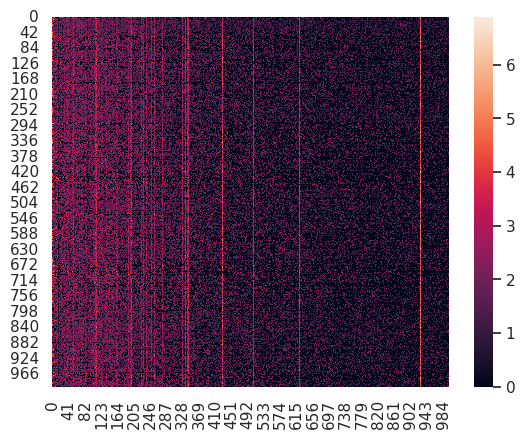

In [18]:
sns.heatmap(adata.X[:1000, :1000])

In [19]:
adata.obs.columns

Index(['barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow',
       'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene',
       'subject', 'position', 'replicate', 'subject_position', 'discard',
       'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6',
       'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11',
       'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15',
       'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19',
       'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23',
       'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27',
       'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess',
       'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM',
       'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA',
       'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP',
       'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP',
    

In [20]:
adata.obsm["cov"] = adata.obs.loc[:, ["row", "col"]].to_numpy()

In [21]:
adata.var_names = adata.var_names.map(ensembl_to_symbol.to_dict())
adata.var_names.duplicated().sum()

0

In [22]:
adata.var_names_make_unique()

For this analysis we extract the prior information from well established databases of gene set collections such as the [MSigDB](http://www.gsea-msigdb.org/gsea/msigdb) and [Reactome](https://reactome.org/). We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [23]:
from famo import feature_sets

In [24]:
hallmark_collection = feature_sets.from_gmt(
    "/home/aqoku/projects/code/MuVI/msigdb/h.all.v7.5.1.symbols.gmt", name="hallmark"
)
reactome_collection = feature_sets.from_gmt(
    "/home/aqoku/projects/code/MuVI/msigdb/c2.cp.reactome.v7.5.1.symbols.gmt",
    name="reactome",
)

kegg_collection = feature_sets.from_gmt(
    "/home/aqoku/projects/code/MuVI/msigdb/c2.cp.kegg.v7.5.1.symbols.gmt",
    name="kegg",
)
# merge both collections
gene_set_collection = hallmark_collection
# gene_set_collection = to_upper(gene_set_collection)
# sorted([fs.name for fs in gene_set_collection])
gene_set_collection

<FeatureSets 'hallmark' with 50 feature sets>

In [25]:
# sorted([fs.name for fs in gene_set_collection if "HAN" in fs.name])

We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [26]:
gene_set_collection = gene_set_collection.filter(
    adata.var_names, min_fraction=0.1, min_count=15, max_count=300
)
# sorted([fs.name for fs in gene_set_collection])
gene_set_collection

<FeatureSets 'hallmark' with 50 feature sets>

In [27]:
gene_set_collection.median_size

105

Generally, the gene set collections inform different views differently. That is, some gene sets may inform a single view only, while other gene sets inform both views jointly. Therefore, we store the prior information into the corresponding `AnnData` inside the `MuData` object. 

In our case, we may only inform the RNA view, and expect the ATAC view to be informed implicitly during the inference of shared latent factors.

Finally, we convert the prior information into a numerical representation such as a binary matrix.

In [28]:
adata.varm["gene_set_mask"] = gene_set_collection.to_mask(
    adata.var_names.tolist()
).T


In [54]:
# Run model with MuData object
model = CORE(device=device)

Setting up device...
- Running all computations on `cuda:2`


In [55]:
model.fit(
    data=mu.MuData({"rna": adata}),
    n_factors=20,
    # annotations={
    #     "rna": torch.Tensor(mdata["rna"].varm["gene_set_mask"].T.values).to(model.device),
    #     "prot": torch.Tensor(mdata["prot"].varm["gene_set_mask"].T.values).to(model.device),
    # },
    # annotations={
    #     "rna": adata.varm["gene_set_mask"].T,
    # },
    # Likelihoods will be inferred automatically from the data if not provided
    # FIXME: This needs to be set to Bernoulli
    likelihoods={
        "rna": "Normal",
    },
    nonnegative_weights=True,
    nonnegative_factors=True,
    factor_prior="Normal",
    weight_prior="Horseshoe",
    covariates_obsm_key="cov",
    prior_penalty=0.003,
    batch_size=10000,
    max_epochs=5000,
    lr=0.005,
    early_stopper_patience=100,
    print_every=500,
    plot_data_overview=False,
    scale_per_group=False,
    use_obs=None,
    use_var=None,
    save=False,
    save_path=None,
    init_factors="random",
    init_scale=0.1,
    # seed=0,
)

- Checking compatibility of provided likelihoods with data.
  - rna: Normal
Initializing factors using `random` method...
Decaying learning rate over 5000 iterations.
Setting training seed to `2409152212`.
Cleaning parameter store.
Epoch:       0 | Time:       0.12s | Loss:   11432.89
Epoch:     100 | Time:       8.46s | Loss:    7501.96
Epoch:     200 | Time:      16.78s | Loss:    5739.09
Epoch:     300 | Time:      25.36s | Loss:    5064.16
Epoch:     400 | Time:      33.63s | Loss:    4881.83
Epoch:     500 | Time:      42.02s | Loss:    4826.17
Epoch:     600 | Time:      50.40s | Loss:    4795.22
Epoch:     700 | Time:      59.09s | Loss:    4777.74
Epoch:     800 | Time:      67.47s | Loss:    4760.94
Epoch:     900 | Time:      75.85s | Loss:    4748.58
Epoch:    1000 | Time:      84.17s | Loss:    4739.31
Epoch:    1100 | Time:      92.40s | Loss:    4731.63
Epoch:    1200 | Time:     100.76s | Loss:    4724.49
Epoch:    1300 | Time:     109.16s | Loss:    4719.39
Epoch:    14

In [56]:
# model.get_annotations()["rna"].sum(axis=1)

In [58]:
# assert (
#     model.data["group_1"]["rna"].var_names == model.get_annotations("pandas")["rna"].columns
# ).all()

In [59]:
# model.factor_names = mdata["rna"].varm["gene_set_mask"].columns.copy()

In [60]:
plot_factor(model)

alt.VConcatChart(...)

In [61]:
plot_variance_explained(model)

alt.HConcatChart(...)

In [62]:
model.factor_names

Index(['Factor 16', 'Factor 10', 'Factor 2', 'Factor 15', 'Factor 5',
       'Factor 12', 'Factor 6', 'Factor 19', 'Factor 8', 'Factor 1',
       'Factor 20', 'Factor 3', 'Factor 18', 'Factor 7', 'Factor 17',
       'Factor 13', 'Factor 14', 'Factor 11', 'Factor 9', 'Factor 4'],
      dtype='object')

In [63]:
model.get_factors("pandas")["group_1"]

,Factor 16,Factor 10,Factor 2,Factor 15,Factor 5,Factor 12,Factor 6,Factor 19,Factor 8,Factor 1,Factor 20,Factor 3,Factor 18,Factor 7,Factor 17,Factor 13,Factor 14,Factor 11,Factor 9,Factor 4
AAACAAGTATCTCCCA-1,0.242831,0.336792,0.000000,0.353540,0.424390,0.094603,0.101946,0.223175,0.295993,0.264018,0.295877,0.221524,0.103871,0.000000,0.148854,0.190021,0.163368,0.000000,0.259904,0.140312
AAACAATCTACTAGCA-1,0.180324,0.000000,0.582745,0.000000,0.253396,0.553029,0.000000,0.024777,0.140870,0.000000,0.000000,0.338266,0.529586,0.000000,0.142861,0.000000,0.281808,0.000000,0.243903,0.000000
AAACACCAATAACTGC-1,0.000000,0.000000,0.430794,0.000000,0.000000,0.158867,0.162798,0.429671,0.131474,0.000000,0.000000,0.235532,0.000000,0.888925,0.270093,0.000000,0.000000,0.235713,0.138026,0.504275
AAACAGAGCGACTCCT-1,0.126309,0.199860,0.564320,0.117511,0.197474,0.647739,0.080342,0.288139,0.000000,0.000000,0.000000,0.307408,0.092401,0.264492,0.281635,0.000000,0.454697,0.000000,0.192312,0.023655
AAACAGCTTTCAGAAG-1,0.000000,0.266295,0.193974,0.302518,0.296673,0.075719,0.390897,0.278314,0.226684,0.307043,0.248725,0.000000,0.229916,0.217268,0.230662,0.174262,0.000000,0.128253,0.185115,0.117933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.519867,0.336099,0.000000,0.252099,0.000000,0.204206,0.000000,0.221439,0.143484,0.257333,0.260761,0.325105,0.137043,0.167692,0.228772,0.289330,0.248359,0.210381,0.173540,0.000000
TTGTTTCACATCCAGG-1,0.360815,0.348386,0.000000,0.421036,0.372480,0.000000,0.000000,0.277720,0.307767,0.238413,0.045435,0.107983,0.000000,0.234989,0.128289,0.208461,0.237686,0.184926,0.140663,0.140355
TTGTTTCCATACAACT-1,0.000000,0.456916,0.000000,0.474314,0.409841,0.000000,0.018672,0.379668,0.328774,0.317814,0.486424,0.000000,0.204992,0.194216,0.227126,0.126645,0.000000,0.159111,0.233513,0.000000
TTGTTTGTATTACACG-1,0.111052,0.000000,0.349212,0.000000,0.040005,0.120414,0.239093,0.118914,0.000000,0.170666,0.223999,0.000000,0.000000,1.610813,0.000000,0.247978,0.201513,0.164354,0.044835,0.280375


/tmp/ipykernel_216269/1262528904.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[i].scatter(covs[:, 0], z_normalized, s=2, label="Inferred", cmap="vlag")


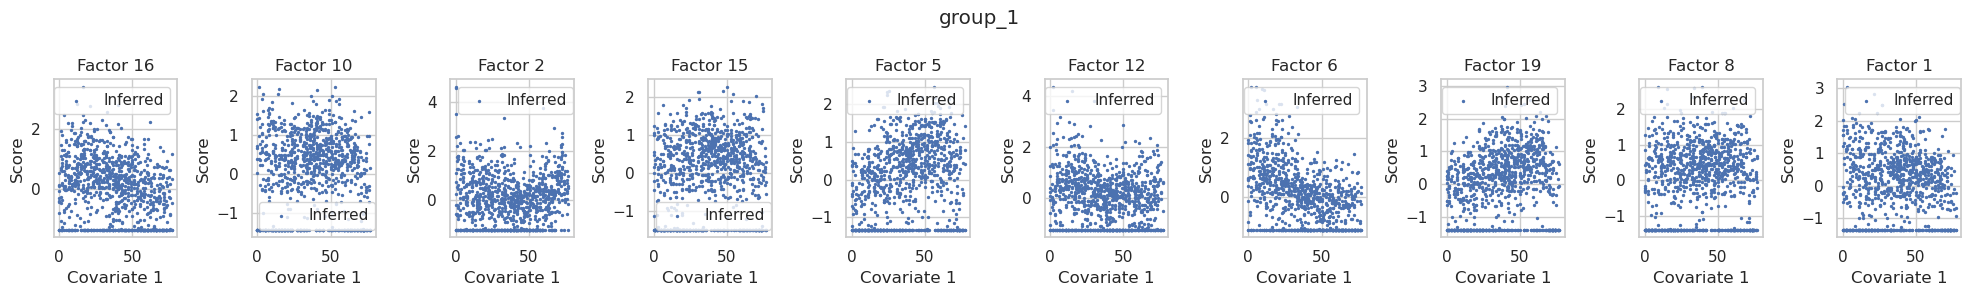

In [80]:
z = {}
for group in model.group_names:
    subsample = np.random.choice(model.n_samples[group], 1000, replace=False)
    z[group] = model.get_factors("pandas")[group].iloc[subsample, 0:10]
    covs = model.covariates[group].cpu().detach().numpy()[subsample, :]
    
    fig, axs = plt.subplots(1, z[group].shape[1], figsize=(int(z[group].shape[1] * 2), 3))
    for i in range(z[group].shape[1]):
        # z_gt_normalized = (z_gt[group].iloc[:, i] - z_gt[group].iloc[:, i].mean()) / z_gt[group].iloc[:, i].std()
        z_normalized = (z[group].iloc[:, i] - z[group].iloc[:, i].mean()) / z[group].iloc[:, i].std()
        axs[i].scatter(covs[:, 0], z_normalized, s=2, label="Inferred", cmap="vlag")
        # axs[i].scatter(covariates[group], z_gt_normalized, c="C1", s=2, label="True")
        axs[i].set_ylabel("Score")
        axs[i].set_xlabel("Covariate 1")
        axs[i].set_title(model.factor_names[i])
        axs[i].legend()
    fig.suptitle(group)
    plt.tight_layout()

/tmp/ipykernel_216269/1232299054.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[i].scatter(covs[:, 1], z_normalized, s=2, label="Inferred", cmap="vlag")


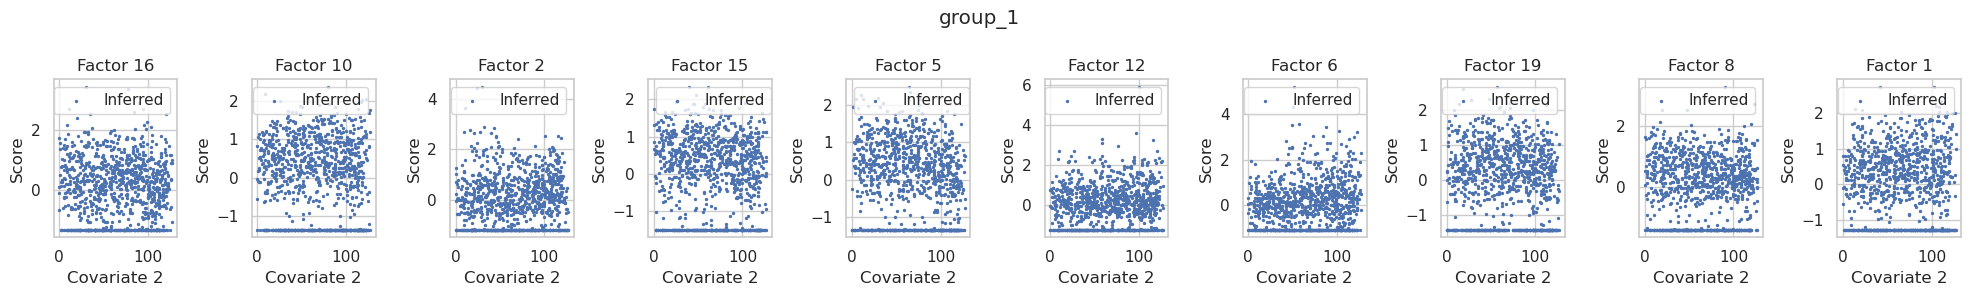

In [81]:
z = {}
for group in model.group_names:
    subsample = np.random.choice(model.n_samples[group], 1000, replace=False)
    z[group] = model.get_factors("pandas")[group].iloc[subsample, 0:10]
    covs = model.covariates[group].cpu().detach().numpy()[subsample, :]
    
    fig, axs = plt.subplots(1, z[group].shape[1], figsize=(int(z[group].shape[1] * 2), 3))
    for i in range(z[group].shape[1]):
        # z_gt_normalized = (z_gt[group].iloc[:, i] - z_gt[group].iloc[:, i].mean()) / z_gt[group].iloc[:, i].std()
        z_normalized = (z[group].iloc[:, i] - z[group].iloc[:, i].mean()) / z[group].iloc[:, i].std()
        axs[i].scatter(covs[:, 1], z_normalized, s=2, label="Inferred", cmap="vlag")
        # axs[i].scatter(covariates[group], z_gt_normalized, c="C1", s=2, label="True")
        axs[i].set_ylabel("Score")
        axs[i].set_xlabel("Covariate 2")
        axs[i].set_title(model.factor_names[i])
        axs[i].legend()
    fig.suptitle(group)
    plt.tight_layout()

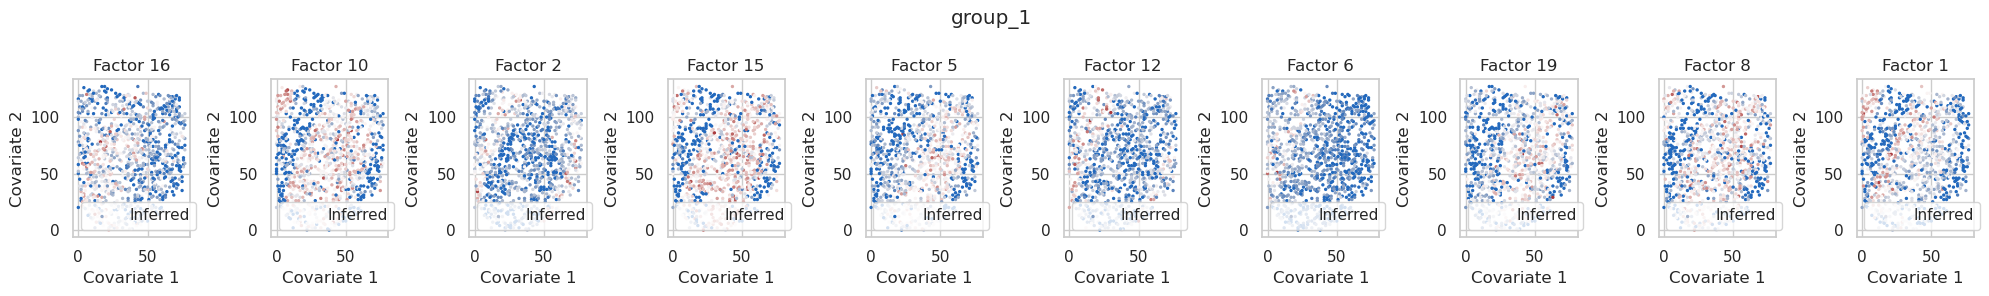

In [82]:
z = {}
for group in model.group_names:
    subsample = np.random.choice(model.n_samples[group], 1000, replace=False)
    z[group] = model.get_factors("pandas")[group].iloc[subsample, 0:10]
    covs = model.covariates[group].cpu().detach().numpy()[subsample, :]
    
    fig, axs = plt.subplots(1, z[group].shape[1], figsize=(int(z[group].shape[1] * 2), 3))
    for i in range(z[group].shape[1]):
        # z_gt_normalized = (z_gt[group].iloc[:, i] - z_gt[group].iloc[:, i].mean()) / z_gt[group].iloc[:, i].std()
        z_normalized = (z[group].iloc[:, i] - z[group].iloc[:, i].mean()) / z[group].iloc[:, i].std()
        axs[i].scatter(covs[:, 0], covs[:, 1], c=z_normalized, s=2, label="Inferred", cmap="vlag")
        # axs[i].scatter(covariates[group], z_gt_normalized, c="C1", s=2, label="True")
        axs[i].set_xlabel("Covariate 1")
        axs[i].set_ylabel("Covariate 2")
        axs[i].set_title(model.factor_names[i])
        axs[i].legend()
    fig.suptitle(group)
    plt.tight_layout()

In [67]:
from famo import plotting

In [68]:
model._cache["factors"] = model.get_factors("anndata")
model._cache["factors"]

{'group_1': AnnData object with n_obs × n_vars = 4273 × 20
     obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'Spatial

In [69]:
# sc.tl.rank_genes_groups(
#     model._cache["factors"]["group_1"], "cell types (high)", method="wilcoxon"
#     # model._cache["factors"]["group_1"], "batch", method="wilcoxon"
# )

In [70]:
# plt.figure(figsize=(20, 6))
# relevant_factors, _ = plotting.groupplot_rank(
#     model, pl_type=plotting.BOXPLOT, top=1, gap=0.1, showfliers=False
# )

In [71]:
# plotting.plot_top_weights(model, view="rna", factor=[1, 2, 3])

In [72]:
# plotting.plot_top_weights_muvi(model, factor_idx="HAN_T CELL")

In [73]:
# sc.pl.rank_genes_groups_dotplot(model._cache["factors"]["group_1"], n_genes=3)

In [74]:
sc.pp.neighbors(model._cache["factors"]["group_1"], use_rep="X")
sc.tl.leiden(model._cache["factors"]["group_1"])
sc.tl.umap(model._cache["factors"]["group_1"])

In [75]:
model._cache["factors"]["group_1"].obs.columns

Index(['barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow',
       'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene',
       'subject', 'position', 'replicate', 'subject_position', 'discard',
       'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6',
       'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11',
       'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15',
       'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19',
       'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23',
       'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27',
       'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess',
       'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM',
       'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA',
       'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP',
       'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP',
    

In [76]:
model._cache["factors"]["group_1"].obs["sample_name"] = model._cache["factors"]["group_1"].obs["sample_name"].astype("category")

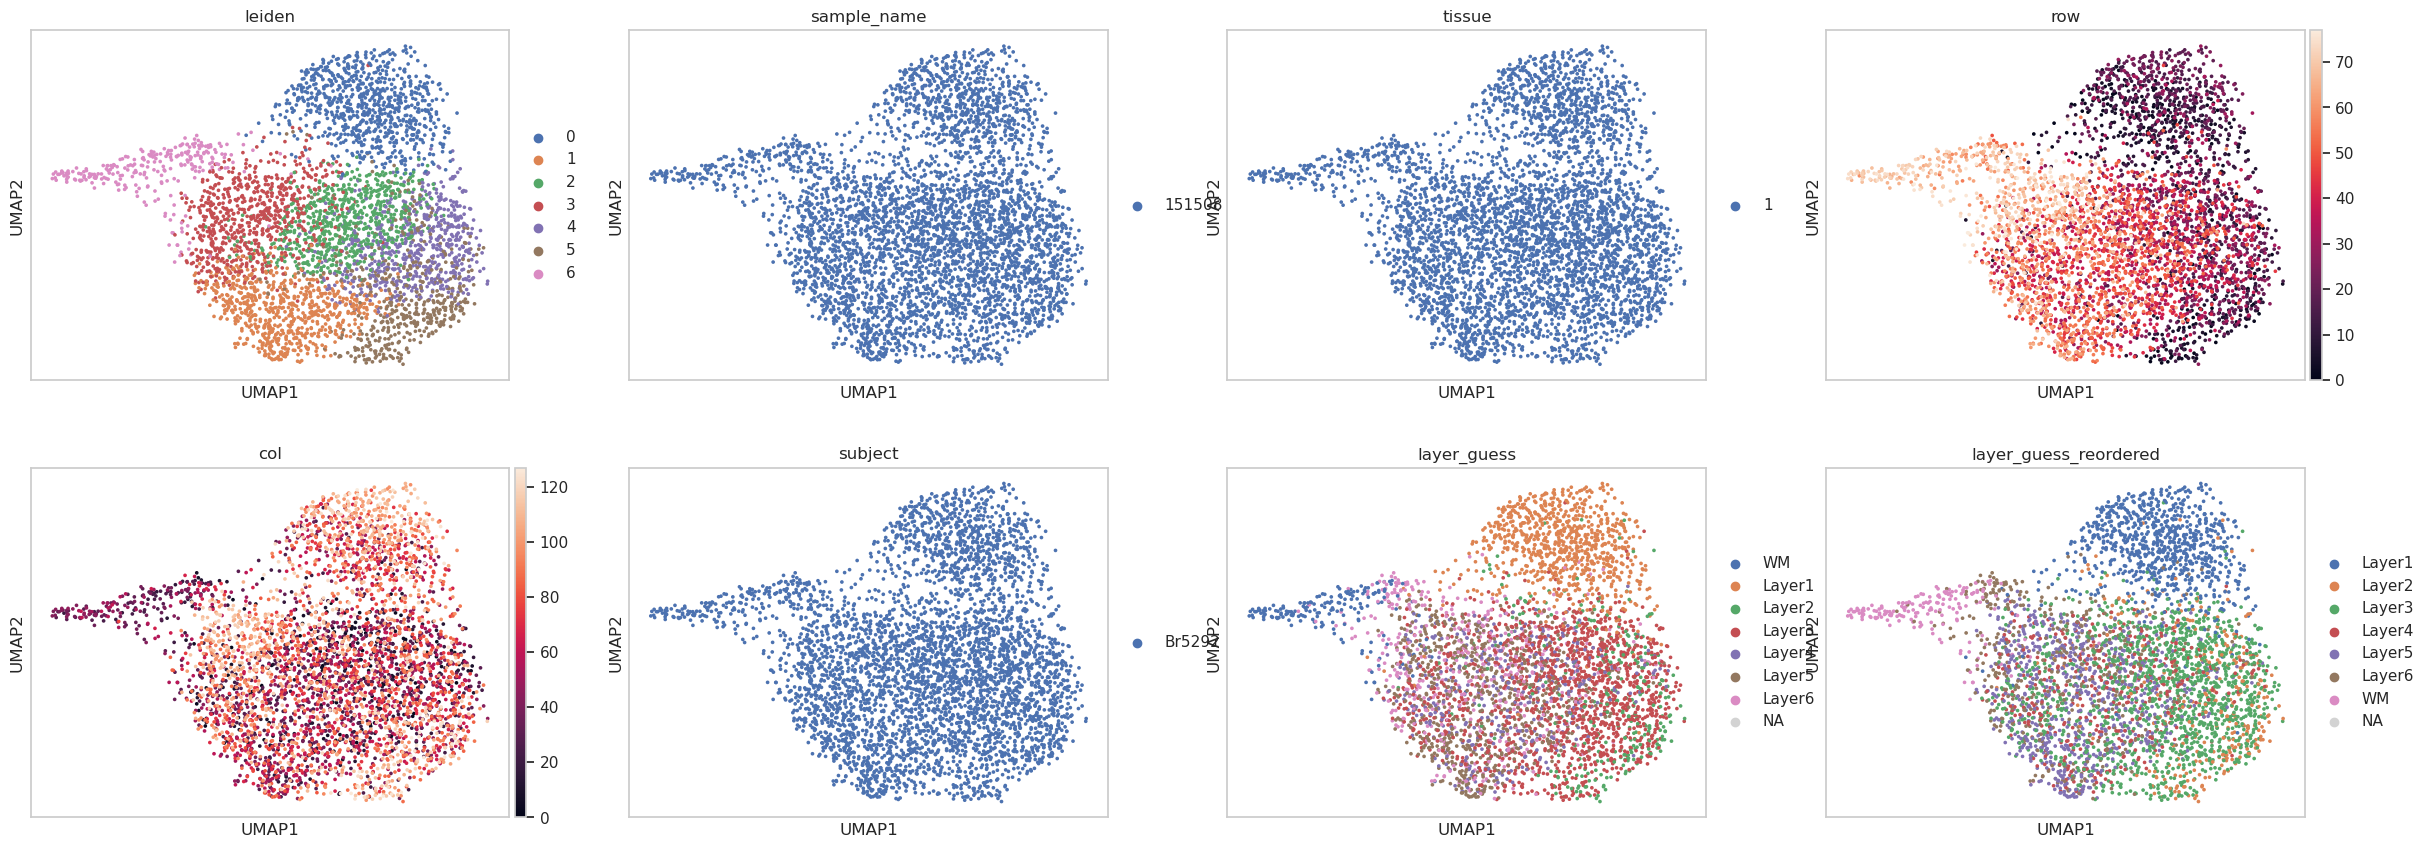

In [77]:
sc.pl.umap(
    model._cache["factors"]["group_1"],
    color=["leiden", "sample_name", "tissue", "row", "col", "subject", "layer_guess", "layer_guess_reordered"],
)

In [78]:
model.factor_names

Index(['Factor 16', 'Factor 10', 'Factor 2', 'Factor 15', 'Factor 5',
       'Factor 12', 'Factor 6', 'Factor 19', 'Factor 8', 'Factor 1',
       'Factor 20', 'Factor 3', 'Factor 18', 'Factor 7', 'Factor 17',
       'Factor 13', 'Factor 14', 'Factor 11', 'Factor 9', 'Factor 4'],
      dtype='object')

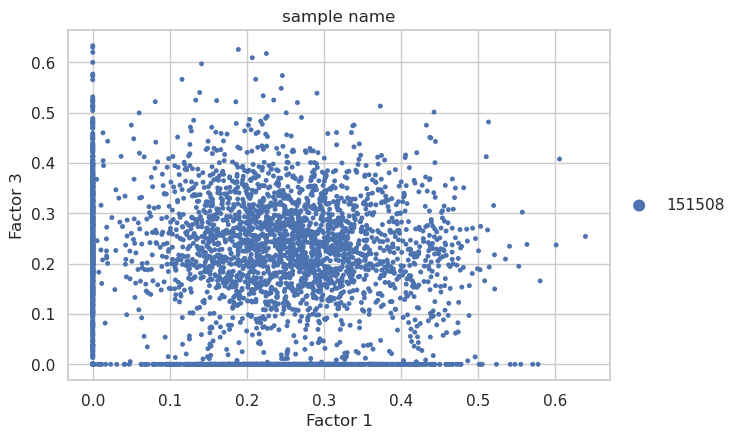

In [79]:
sc.pl.scatter(
    model._cache["factors"]["group_1"],
    x="Factor 1",
    y="Factor 3",
    color="sample_name",
    size=50,
)